# Notebook 4: Efficient Location and Time Series Access Using Polytope Feature Extraction

Notebook 4 showcases efficient geo-location and time series access using polytope feature extraction. By leveraging this feature, we significantly reduce data retrieval from storage, optimizing workflows and resource utilization.

1. **Configuring Access to FDB**

In [1]:
import os
import dataclasses as dc
from meteodatalab import mars


os.environ["POLYTOPE_USERNAME"] = "admin"
os.environ["POLYTOPE_PASSWORD"] = "xxxxxxxxxxxxxxxxx"
os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"


2. **Selecting geo-location point of interest**

In [2]:
zrh = mars.Point(47.47, 8.55)

3. **Querying the data** <br>
The `feature` attribute tells polytope to extract **only the relevant data at the given point**.
The amount of data that is retrieved from storage is signficantly reduced.

In [3]:
request = mars.Request(
    param="T_2M",
    date="20240222",
    time="0000",
    model=mars.Model.ICON_CH1_EPS,
    levtype=mars.LevType.SURFACE,
    number=1,
    feature=mars.TimeseriesFeature(points=[zrh], end=1440),
)

# mars.Request is a dataclass
requests = [dc.replace(request, date=str(d)) for d in range(20240414, 20240425)]
requests

[Request(param='T_2M', date='20240414', time='0000', expver='0001', levelist=None, number=1, step=None, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH1-EPS', stream='enfo', type='ememb', feature=TimeseriesFeature(type=<FeatureType.TIMESERIES: 'timeseries'>, points=[Point(lat=47.47, lon=8.55)], start=0, end=1440)),
 Request(param='T_2M', date='20240415', time='0000', expver='0001', levelist=None, number=1, step=None, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH1-EPS', stream='enfo', type='ememb', feature=TimeseriesFeature(type=<FeatureType.TIMESERIES: 'timeseries'>, points=[Point(lat=47.47, lon=8.55)], start=0, end=1440)),
 Request(param='T_2M', date='20240416', time='0000', expver='0001', levelist=None, number=1, step=None, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH1-EPS', stream='enfo', type='ememb', feature=TimeseriesFeature(type=<FeatureType.TIMESERIES: 'timeseries'>, points=[Point(lat=47.47, lon=8.55)], start=0

In [4]:
from concurrent.futures import ThreadPoolExecutor
from meteodatalab import mch_model_data
import xarray as xr

with ThreadPoolExecutor(max_workers=5) as exec:
    ds = list(exec.map(mch_model_data.get_from_polytope, requests))

t_2m = xr.concat([a["2m Temperature"] for a in ds], dim="t")


2024-04-25 07:37:13 - INFO - Sending request...
{'request': 'class: od\n'
            "date: '20240415'\n"
            "expver: '0001'\n"
            'feature:\n'
            '  end: 1440\n'
            '  points:\n'
            '  - - 47.47\n'
            '    - 8.55\n'
            '  start: 0\n'
            '  type: timeseries\n'
            'levtype: sfc\n'
            'model: icon-ch1-eps\n'
            'number: 1\n'
            "param: '500011'\n"
            'stream: enfo\n'
            "time: '0000'\n"
            'type: ememb\n',
 'verb': 'retrieve'}
2024-04-25 07:37:13 - INFO - Sending request...
{'request': 'class: od\n'
            "date: '20240414'\n"
            "expver: '0001'\n"
            'feature:\n'
            '  end: 1440\n'
            '  points:\n'
            '  - - 47.47\n'
            '    - 8.55\n'
            '  start: 0\n'
            '  type: timeseries\n'
            'levtype: sfc\n'
            'model: icon-ch1-eps\n'
            'number: 1\n'
          

4. **Visualizing the data**

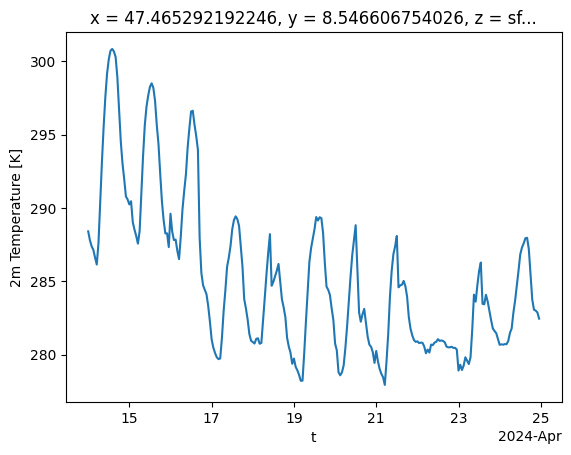

In [5]:
t_2m.plot()


# Source: https://nwp-polytope-test.s3.eu-central-2.amazonaws.com/5ddc3f38-2b49-4e49-9f4f-c2287d85e15c
